* PilotNet + Visual back prop.
* See, 
    * https://arxiv.org/abs/1704.07911
    * https://devblogs.nvidia.com/explaining-deep-learning-self-driving-car/

* Using dataset is udacity self-driving dataset. see, 
    * https://github.com/udacity/self-driving-car
    * https://github.com/rwightman/udacity-driving-reader

In [1]:
import functools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
target_output_path = './udacity-driving-reader/legacy_data_sunny/output/'

df_camera = pd.read_csv(target_output_path + 'camera.csv')
df_steering = pd.read_csv(target_output_path + 'steering.csv')

df_camera = df_camera[df_camera['frame_id'] == 'center_camera']
df_camera['timestamp'] = pd.to_datetime(df_camera['timestamp'])
df_camera.set_index(['timestamp'], inplace=True)
df_camera.index.rename('index', inplace=True)

df_steering['timestamp'] = pd.to_datetime(df_steering['timestamp'])
df_steering.set_index(['timestamp'], inplace=True)
df_steering.index.rename('index', inplace=True)

df_merged = functools.reduce(lambda left, right: pd.merge(left, right, how='outer', left_index=True, right_index=True), [df_camera, df_steering])
df_merged.interpolate(method='time', inplace=True)
df_filtered = df_merged.loc[df_camera.index]
df_filtered.fillna(0.0, inplace=True)
df_filtered.index.rename('timestamp', inplace=True)
df_filtered = df_filtered.reset_index()
df_filtered = df_filtered[['timestamp', 'filename', 'angle', 'speed']]
df_filtered['filename'] = target_output_path + df_filtered['filename']

print(len(df_filtered))
df_filtered.head()

15212


,timestamp,filename,angle,speed
0,2016-09-29 22:09:25.609972775,./udacity-driving-reader/legacy_data_sunny/out...,-0.046314,14.607044
1,2016-09-29 22:09:25.659735933,./udacity-driving-reader/legacy_data_sunny/out...,-0.047099,14.616667
2,2016-09-29 22:09:25.709975321,./udacity-driving-reader/legacy_data_sunny/out...,-0.043633,14.613889
3,2016-09-29 22:09:25.759787059,./udacity-driving-reader/legacy_data_sunny/out...,-0.040143,14.625130
4,2016-09-29 22:09:25.809874186,./udacity-driving-reader/legacy_data_sunny/out...,-0.036652,14.617870


* Build features from dataset.

In [3]:
df_filtered = df_filtered[10 < df_filtered['speed']]
df_filtered = df_filtered[(-0.5 <= df_filtered['angle']) & (df_filtered['angle'] <= 0.5)]
df_filtered['angle'] += 0.5
df_filtered = df_filtered.sample(frac=1)

print(len(df_filtered))
df_filtered.head()

8532


,timestamp,filename,angle,speed
5599,2016-09-29 22:14:05.598862344,./udacity-driving-reader/legacy_data_sunny/out...,0.506981,15.340702
13051,2016-09-29 22:20:18.250821594,./udacity-driving-reader/legacy_data_sunny/out...,0.554105,12.630825
7062,2016-09-29 22:15:18.759238863,./udacity-driving-reader/legacy_data_sunny/out...,0.563919,20.592873
13159,2016-09-29 22:20:23.651847783,./udacity-driving-reader/legacy_data_sunny/out...,0.713841,10.234238
5335,2016-09-29 22:13:52.397274313,./udacity-driving-reader/legacy_data_sunny/out...,0.494764,17.333743


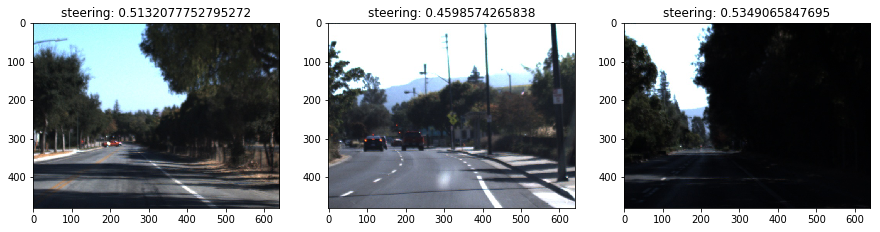

In [4]:
df = df_filtered.sample(frac=1)[:3]

fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

for i, (index, row) in enumerate(df.iterrows()):
    img = Image.open(row['filename'])
    axs[i].imshow(img)
    axs[i].set_title('steering: {}'.format(row['angle']))
    
plt.show()

In [5]:
valid_size = 1000
df_train = df_filtered[:(len(df_filtered)-valid_size)]
df_valid = df_filtered[(len(df_filtered)-valid_size):]
df_train = df_train.sample(frac=1)
len(df_train), len(df_valid)

(7532, 1000)

In [7]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from tqdm import tqdm

In [8]:
def processing_x(x):
    
    # x: PIL.Image
    w, h = x.size
    x = x.crop(((w//8)*1, (h//8)*5, (w//8)*7, (h//8)*8)) # (upper left x, upper left y, lower right x, lower right y)
    x = x.resize((200, 66))
    x = np.array(x, dtype=np.float32)
    x /= 255
    x = x.transpose(2, 0, 1)
    return x

def processing_y(y):
    
    # y: float
    y = np.array([y], dtype=np.float32)
    return y

In [9]:
class TransformDataset(chainer.dataset.DatasetMixin):
    
    def __init__(self, data, train=True):
        self.data = data
        self.train = train
        
    def __len__(self):
        return len(self.data)
        
    def get_example(self, i):
        x, y = self.data[i][0], self.data[i][1]
        return x, y

In [10]:
train_x = df_train['filename'].as_matrix()
train_y = df_train['angle'].as_matrix()
valid_x = df_valid['filename'].as_matrix()
valid_y = df_valid['angle'].as_matrix()
train_dataset = [(processing_x(Image.open(str(x))), processing_y(float(y))) for x, y in tqdm(zip(train_x, train_y), total=len(train_x))]
valid_dataset = [(processing_x(Image.open(str(x))), processing_y(float(y))) for x, y in tqdm(zip(valid_x, valid_y), total=len(valid_x))]
train_dataset = TransformDataset(train_dataset)
valid_dataset = TransformDataset(valid_dataset)
len(train_dataset), len(valid_dataset)

100%|██████████| 1000/1000 [00:12<00:00, 77.83it/s]


(7532, 1000)

* Set PilotNet model and Visual back prop alg..

In [11]:
class PilotNet(chainer.Chain):
    
    def __init__(self):
        
        super(PilotNet, self).__init__()
        with self.init_scope():
            
            self.bn0 = L.BatchNormalization(3)
            self.conv1 = L.Convolution2D(3, 24, ksize=5, stride=2)
            self.conv2 = L.Convolution2D(24, 36, ksize=5, stride=2)
            self.conv3 = L.Convolution2D(36, 48, ksize=5, stride=2)
            self.conv4 = L.Convolution2D(48, 64, ksize=3)
            self.conv5 = L.Convolution2D(64, 64, ksize=3)
            self.fc6 = L.Linear(None, 100)
            self.fc7 = L.Linear(100, 50)
            self.fc8 = L.Linear(50, 10)
            self.fc9 = L.Linear(10, 1)
            
    def __call__(self, x, extract_feature=False):
        
        h0 = self.bn0(x)
        h1 = F.relu(self.conv1(h0))
        h2 = F.relu(self.conv2(h1))
        h3 = F.relu(self.conv3(h2))
        h4 = F.relu(self.conv4(h3))
        h5 = F.relu(self.conv5(h4))
        h6 = F.dropout(F.relu(self.fc6(h5)), ratio=0.1)
        h7 = F.dropout(F.relu(self.fc7(h6)), ratio=0.1)
        h8 = F.dropout(F.relu(self.fc8(h7)), ratio=0.1)
        y = self.fc9(h8)
        
        if extract_feature:
            
            return {'conv1': h1, 'conv2': h2, 'conv3': h3, 'conv4': h4, 'conv5': h5, 'fc6': h6, 'fc7': h7, 'fc8': h8, 'fc9': y}
        
        return y
    
    def get_mask(self, x):
        
        h0 = self.bn0(x)
        h1 = F.relu(self.conv1(h0))
        h2 = F.relu(self.conv2(h1))
        h3 = F.relu(self.conv3(h2))
        h4 = F.relu(self.conv4(h3))
        h5 = F.relu(self.conv5(h4))
        
        h5 = F.mean(h5, axis=1)
        h5 = F.reshape(h5, (h5.data.shape[0], 1, h5.data.shape[1], h5.data.shape[2]))
        h5 = chainer.cuda.to_cpu(h5.data)
        h4_rev = L.Deconvolution2D(1, 1, ksize=3,
                                 initialW=np.ones((1, 1, 3, 3), dtype=np.float32),
                                 initial_bias=np.zeros((1), dtype=np.float32))(h5)
        h4 = F.mean(h4, axis=1)
        h4 = F.reshape(h4, (h4.data.shape[0], 1, h4.data.shape[1], h4.data.shape[2]))
        h4 = chainer.cuda.to_cpu(h4.data)
        h3_rev = L.Deconvolution2D(1, 1, ksize=3,
                                  initialW=np.ones((1, 1, 3, 3), dtype=np.float32),
                                  initial_bias=np.zeros((1), dtype=np.float32))(h4_rev*h4)
        h3 = F.mean(h3, axis=1)
        h3 = F.reshape(h3, (h3.data.shape[0], 1, h3.data.shape[1], h3.data.shape[2]))
        h3 = chainer.cuda.to_cpu(h3.data)
        h2_rev = L.Deconvolution2D(1, 1, ksize=5, stride=2, outsize=(h2.data.shape[2], h2.data.shape[3]),
                                  initialW=np.ones((1, 1, 5, 5), dtype=np.float32),
                                  initial_bias=np.zeros((1), dtype=np.float32))(h3_rev*h3)
        h2 = F.mean(h2, axis=1)
        h2 = F.reshape(h2, (h2.data.shape[0], 1, h2.data.shape[1], h2.data.shape[2]))
        h2 = chainer.cuda.to_cpu(h2.data)
        h1_rev = L.Deconvolution2D(1, 1, ksize=5, stride=2, outsize=(h1.data.shape[2], h1.data.shape[3]),
                                  initialW=np.ones((1, 1, 5, 5), dtype=np.float32),
                                  initial_bias=np.zeros((1), dtype=np.float32))(h2_rev*h2)
        h1 = F.mean(h1, axis=1)
        h1 = F.reshape(h1, (h1.data.shape[0], 1, h1.data.shape[1], h1.data.shape[2]))
        h1 = chainer.cuda.to_cpu(h1.data)
        mask = L.Deconvolution2D(1, 1, ksize=5, stride=2, outsize=(h0.data.shape[2], h0.data.shape[3]),
                                initialW=np.ones((1, 1, 5, 5), dtype=np.float32),
                                initial_bias=np.zeros((1), dtype=np.float32))(h1_rev*h1)
        
        return mask

In [12]:
gpu = 0

In [13]:
model = L.Classifier(PilotNet(), lossfun=F.mean_squared_error)
model.compute_accuracy = False
optimizer = chainer.optimizers.Adam(alpha=1e-4)
optimizer.setup(model)

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

* Train model.

In [14]:
epoch_num = 100
batch_size = 1000

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size, repeat=False, shuffle=False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result_pilotnet')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu))
trainer.extend(extensions.LogReport(trigger=(10, 'epoch')))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], 'epoch', file_name='loss.png'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch_{.updater.epoch}.npz'), trigger=(epoch_num, 'epoch'))
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
10          0.0309514   0.0388316             82.0616       
20          0.0122537   0.00430815            149.306       
30          0.00964154  0.00319876            216.603       
40          0.0084587   0.00268209            284.642       
50          0.00782145  0.0022793             351.935       
60          0.00739421  0.00230404            419.19        
70          0.00697377  0.00171783            487.325       
80          0.00672234  0.00163945            554.637       
90          0.00637599  0.00138362            622.032       
100         0.00623202  0.00120607            690.019       


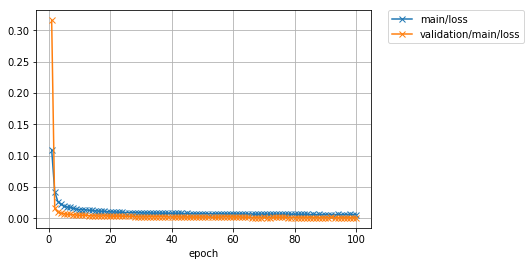

In [15]:
Image.open('result_pilotnet/loss.png')

* Check model performances.

In [16]:
model = L.Classifier(PilotNet(), lossfun=F.mean_squared_error)
model.compute_accuracy = False
chainer.serializers.load_npz('result_pilotnet/snapshot_epoch_{}.npz'.format(epoch_num), model, path='updater/model:main/')

In [17]:
test_iter = chainer.iterators.SerialIterator(valid_dataset, len(valid_dataset), repeat=False, shuffle=False)
batch = test_iter.next()
x, y = chainer.dataset.concat_examples(batch, -1)

with chainer.using_config('train', False):
    
    pre = model.predictor(x)
    
    mse = F.mean_squared_error(pre, y)
    mae = F.mean_absolute_error(pre, y)
    
print('Mean squared error: {:.5f}'.format(mse.data))
print('Mean absolute error: {:.5f}'.format(mae.data))

Mean squared error: 0.00109
Mean absolute error: 0.02312


* Check Visual back prop.

In [18]:
from sklearn.preprocessing import MinMaxScaler
from PIL import ImageEnhance

/usr/local/lib/python3.6/dist-packages/chainer/functions/normalization/batch_normalization.py:67: UserWarning: A batch with no more than one sample has been given to F.batch_normalization. F.batch_normalization will always output a zero tensor for such batches. This could be caused by incorrect configuration in your code (such as running evaluation while chainer.config.train=True), but could also happen in the last batch of training if non-repeating iterator is used.
  UserWarning)


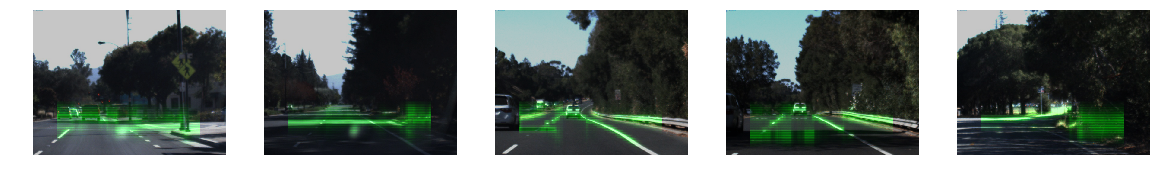

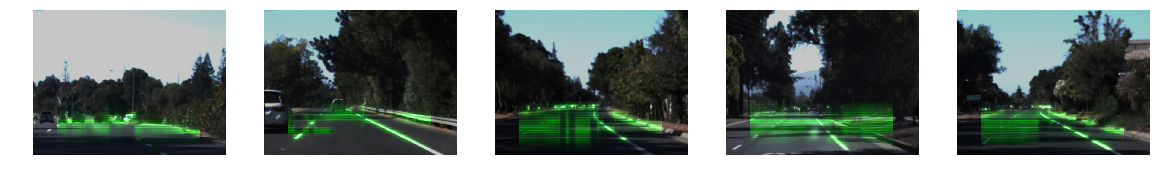

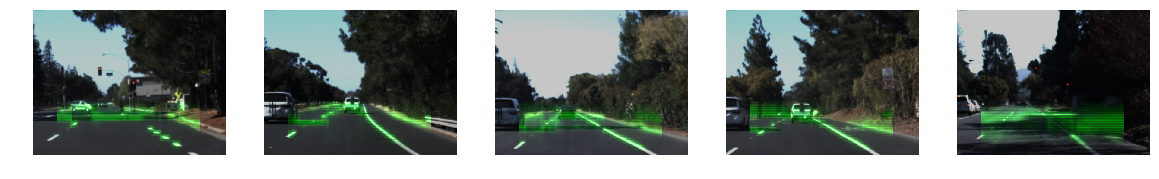

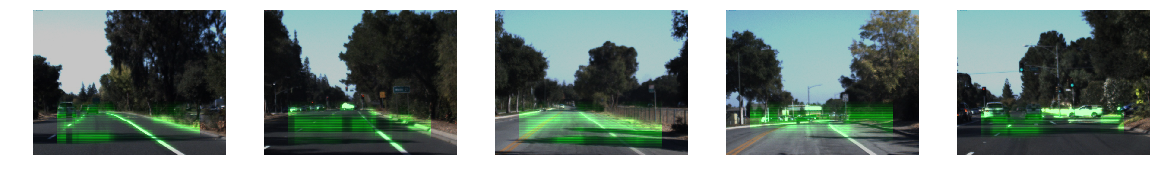

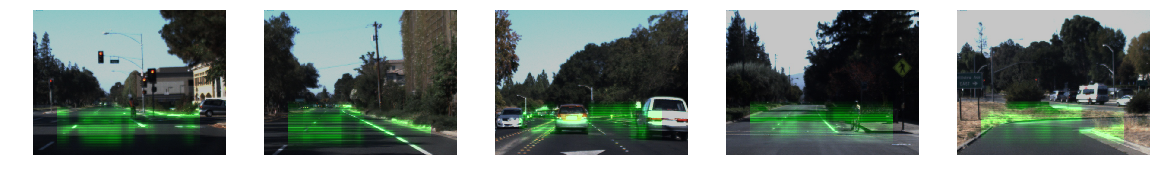

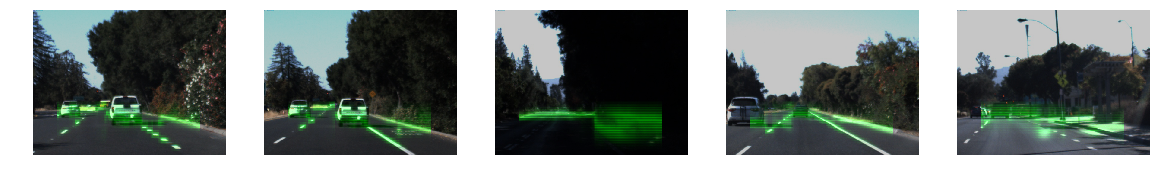

In [19]:
col_num = 5

for i, (x, y) in enumerate(zip(valid_x, valid_y)):
    
    if i >= 30:
        break
    
    if i % col_num == 0:
        
        fig, axs = plt.subplots(ncols=col_num, figsize=(20, 4))
    
    img = Image.open(x)
    
    x = processing_x(img)
    x = x[np.newaxis]
    
    mask = model.predictor.get_mask(x)
    mask = MinMaxScaler().fit_transform(mask.data.squeeze())
    
    w, h = img.size
    mask *= 255
    mask = Image.fromarray(mask).convert('L')
    mask = mask.resize((((w//8)*7 - (w//8)*1), ((h//8)*8 - (h//8)*5)))
    mask = Image.merge('RGB', (mask.point(lambda x: x * 0 / 255), mask.point(lambda x: x * 255 / 255), mask.point(lambda x: x * 0 / 255)))
    
    overlay = Image.new('RGB', (w, h))
    overlay.paste(mask, ((w//8)*1, (h//8)*5))
    
    blended = Image.blend(img, overlay, 0.4)
    enhancer = ImageEnhance.Brightness(blended)
    blended = enhancer.enhance(1.3)
    axs[i % col_num].imshow(blended)
    axs[i % col_num].axis('off')
    
plt.show()

In [20]:
!python --version

Python 3.6.3


In [21]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
certifi==2018.4.16
chainer==4.0.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0.2.0
pexpect==4.5.0
pickleshare==0.7.4
Pillow==5.1.0
prompt-toolkit==1.0.15
protobuf==3.5.2.post1
ptyprocess==0.5.2
pycurl==7.43.0
Pygments==2.2.0
pygobjec

In [22]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [23]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
